# STEP 0. 필요모듈 임포트

In [1]:
# 필요모드 임포트

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34


SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.10.0
Num GPUs Available: 1


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12565871186391129073
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6248464384
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10308358948694293288
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:07:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


# STEP 1. 도입전 기본처리

In [4]:
# CIFAR 10 데이터 살펴보기
cifar10 = keras.datasets.cifar10
((train_images,train_labels),(test_images,test_labels)) = cifar10.load_data()

In [5]:
# train_images/labels와 test_images/labels의 shape 출력
print('train_images.shape : {}'.format(train_images.shape))
print("train_images.type : {}".format(train_images.dtype))

print('train_labels.shape : {}'.format(train_labels.shape))
print("train_labels.type : {}".format(train_labels.dtype))

print('test_images.shape : {}'.format(test_images.shape))
print("test_images.type : {}".format(test_images.dtype))

print('test_labels.shape : {}'.format(test_labels.shape))
print("test_labels.type : {}".format(test_labels.dtype))




train_images.shape : (50000, 32, 32, 3)
train_images.type : uint8
train_labels.shape : (50000, 1)
train_labels.type : uint8
test_images.shape : (10000, 32, 32, 3)
test_images.type : uint8
test_labels.shape : (10000, 1)
test_labels.type : uint8


In [6]:
# Lable 데이터 flattening
train_labels = train_labels.reshape(-1)
test_labels = test_labels.reshape(-1)

print("train_labels.shape : {}".format(train_labels.shape))
print("test_labels.shape : {}".format(test_labels.shape))

train_labels.shape : (50000,)
test_labels.shape : (10000,)


In [7]:
# 레이블설정 (idx -> 품목이름)
labels = ["Airplane",
         "Automobile",
         "Bird",
         "Cat",
         "Deer",
         "Dog",
         "Frog",
         "Horse",
         "Ship",
         "Truc"]

def idx2label(idx):
    return labels[idx]

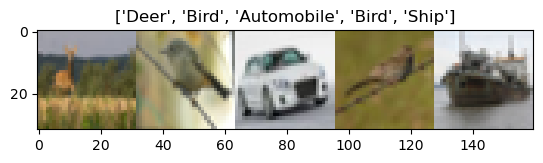

In [8]:
# (32, 32*5, 3) 형태의 이미지를 plt 이용해 출력
indices = np.random.choice(range(len(train_images)), size=5, replace=False)

labels_sel = list(map(idx2label, train_labels[indices]))

def show_image(indices):    
    plt.imshow(train_images[indices].transpose((1,0,2,3)).reshape((32,-1,3)))
    plt.title(labels_sel)
    plt.show()
    
show_image(indices)

In [9]:
# train_images에서 0이 아닌 값들을 출력
train_images[train_images!=0][:5]

array([59, 62, 63, 43, 46], dtype=uint8)

In [10]:
# 이미지의 값이 중 가장 큰 idx와 가장 작은 idx을 출력
print(train_images.reshape(len(train_images),-1).sum(axis=1).argmax())
print(train_images.reshape(len(train_images),-1).sum(axis=1).argmin())

9881
44590


# STEP 2. 전처리

In [11]:
# train/test 이미지 범위 확인
# 이미지 데디터 범위 확인
print(train_images.shape, test_images.shape)
print(train_images.dtype, test_images.dtype)


(50000, 32, 32, 3) (10000, 32, 32, 3)
uint8 uint8


In [12]:
# train/test 이미지의 데이터 최소/최대값 출력

print('train_images.shape : {}'.format(train_images.shape))
print("train_images.type : {}".format(train_images.dtype))
print("train_images Min/Max : {}/{}".format(train_images.min(), train_images.max()))

print('---------------------------------------------')

print('train_labels.shape : {}'.format(train_labels.shape))
print("train_labels.type : {}".format(train_labels.dtype))
print("train_labels Min/Max : {}/{}".format(train_labels.min(), train_labels.max()))

print('---------------------------------------------')

print('test_images.shape : {}'.format(test_images.shape))
print("test_images.type : {}".format(test_images.dtype))
print("test_images Min/Max : {}/{}".format(test_images.min(), test_images.max()))

print('---------------------------------------------')

print('test_labels.shape : {}'.format(test_labels.shape))
print("test_labels.type : {}".format(test_labels.dtype))
print("test_labels Min/Max : {}/{}".format(test_labels.min(), test_labels.max()))

print('---------------------------------------------')



train_images.shape : (50000, 32, 32, 3)
train_images.type : uint8
train_images Min/Max : 0/255
---------------------------------------------
train_labels.shape : (50000,)
train_labels.type : uint8
train_labels Min/Max : 0/9
---------------------------------------------
test_images.shape : (10000, 32, 32, 3)
test_images.type : uint8
test_images Min/Max : 0/255
---------------------------------------------
test_labels.shape : (10000,)
test_labels.type : uint8
test_labels Min/Max : 0/9
---------------------------------------------


In [13]:
# 정수형을 실수형으로 변경 후 dtype으로 비교후 실수로 전환
train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)


print("train_images Min/Max : {}/{}".format(train_images.min(), train_images.max()))
print("train_images type : {}".format(train_images.dtype))

print('---------------------------------------------')

print("test_images Min/Max : {}/{}".format(test_images.min(), test_images.max()))
print("test_images type : {}".format(test_images.dtype))

print('---------------------------------------------')

train_images Min/Max : 0.0/255.0
train_images type : float32
---------------------------------------------
test_images Min/Max : 0.0/255.0
test_images type : float32
---------------------------------------------


In [14]:
# 데이터 0-1 노말라이즈 수행
def norm(data):
    min_v = data.min()
    max_v = data.max()
    return (data-min_v)/(max_v-min_v)


train_images = norm(train_images)
test_images = norm(test_images)

print(list(filter(lambda x : x != 0, train_images[0].reshape(-1)))[:10])
print('---------------------------------------------')
print(list(filter(lambda x : x != 0, train_labels.reshape(-1)))[:10])
print('---------------------------------------------')
print(list(filter(lambda x : x != 0, test_images[0].reshape(-1)))[:10])
print('---------------------------------------------')
print(list(filter(lambda x : x != 0, test_labels.reshape(-1)))[:10])
print('---------------------------------------------')

print('train_images.shape : {}'.format(train_images.shape))
print("train_images.type : {}".format(train_images.dtype))
print("train_images Min/Max : {}/{}".format(train_images.min(), train_images.max()))

print('---------------------------------------------')

print('train_labels.shape : {}'.format(train_labels.shape))
print("train_labels.type : {}".format(train_labels.dtype))
print("train_labels Min/Max : {}/{}".format(train_labels.min(), train_labels.max()))

print('---------------------------------------------')

print('test_images.shape : {}'.format(test_images.shape))
print("test_images.type : {}".format(test_images.dtype))
print("test_images Min/Max : {}/{}".format(test_images.min(), test_images.max()))

print('---------------------------------------------')

print('test_labels.shape : {}'.format(test_labels.shape))
print("test_labels.type : {}".format(test_labels.dtype))
print("test_labels Min/Max : {}/{}".format(test_labels.min(), test_labels.max()))

print('---------------------------------------------')


[0.23137255, 0.24313726, 0.24705882, 0.16862746, 0.18039216, 0.1764706, 0.19607843, 0.1882353, 0.16862746, 0.26666668]
---------------------------------------------
[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]
---------------------------------------------
[0.61960787, 0.4392157, 0.19215687, 0.62352943, 0.43529412, 0.18431373, 0.64705884, 0.45490196, 0.2, 0.6509804]
---------------------------------------------
[3, 8, 8, 6, 6, 1, 6, 3, 1, 9]
---------------------------------------------
train_images.shape : (50000, 32, 32, 3)
train_images.type : float32
train_images Min/Max : 0.0/1.0
---------------------------------------------
train_labels.shape : (50000,)
train_labels.type : uint8
train_labels Min/Max : 0/9
---------------------------------------------
test_images.shape : (10000, 32, 32, 3)
test_images.type : float32
test_images Min/Max : 0.0/1.0
---------------------------------------------
test_labels.shape : (10000,)
test_labels.type : uint8
test_labels Min/Max : 0/9
---------------------------

# STEP 3. 시각화 방법

In [15]:
# train_image의 이미지를 5장 획득하여 (5,28,28)의 shape을 출력
indices = np.random.choice(range(len(train_images)), size=5, replace=False)
train_images[indices].shape

(5, 32, 32, 3)

(32, 160, 3)


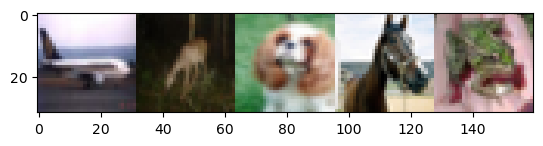

In [16]:
# hstack을 이용한 변환
print(np.hstack(train_images[indices]).shape)
plt.imshow(np.hstack(train_images[indices]))

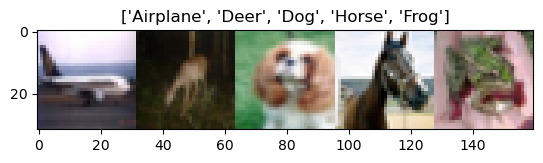

In [17]:
# np.hstack은 tensorflow에서 사용가능한 방법이 아니므로 transpose 함수를 이용하여 (28,28,5)을 변환
# numpy는 CPU 영역에서 동작하기 때문에 GPU를 최대한 활용하기 위해서는 tanspose 함수 쓰기

labels_sel = list(map(idx2label, train_labels[indices]))
# print(train_images[indices].transpose(1, 0, 2).reshape(28, -1).shape) # (batch, height, width) -> (height, batch, width)로 변환
plt.imshow(train_images[indices].transpose(1, 0, 2, 3).reshape(32, -1, 3)) # 그냥 reshape으로 변환하면 imshow에서 받아들이지 못함
plt.title(labels_sel)
plt.show()
# print("labels : {}".format(train_labels[indices]))

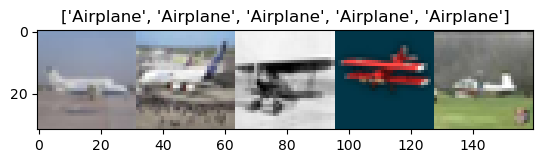

In [18]:
# 레이블에 따라 5개르 출력하는 함수
target_idx = 0

indices = np.where(train_labels == target_idx)[0]
indices = np.random.choice(indices, size=5, replace=False)
labels_sel = list(map(idx2label, train_labels[indices]))
plt.imshow(train_images[indices].transpose(1, 0, 2, 3).reshape(32, -1, 3)) # 그냥 reshape으로 변환하면 imshow에서 받아들이지 못함
plt.title(labels_sel)
plt.show()


# STEP 4. Data augmentation - 이미지 확대 및 다객체 추가 방법

In [19]:
# 기본랜덤변환 (Rnadom flip & crop 등등)
# Random Flip : 이미지를 좌우로 무작위로 뒤집어서 모델이 좌/우 방향에 덜 민감하도록
# Random Crop :  약간의 패딩 후 무작위 위치를 잘라 원래 크기로 복원. 전통적인 증강방법
# Colot Jitter : 밝기, 대비, 채도 등 옵션으로 추가가능
# ---> 가장 기본적이면서 효과가 좋은 방법

def random_flip_and_crop(image):
    # 1) Random flip
    image = tf.image.random_flip_left_right(image)
    
    # 2) Random crop
    # 먼저 패딩을 주고, (32,32,3)을 다시 크롭
    # CIFAR-10에서 흔히 pad=4로 사용
    image = tf.image.resize_with_crop_or_pad(image, 32 + 2*4, 32 + 2*4)  # (40, 40, 3)
    image = tf.image.random_crop(image, size=[32, 32, 3])
    
    return image


# 두개의 샘플 데이터를 혼합하여 새로운 학습 데이터를 만드는 기술
# 분류에서는 좋은 성능을 나타낼 수 있지만 자연스럽지 않은 데이터를 만들어냄  -> 지역화 작업에서 혼란유발
# 몇 논문에서는 cutmix 방법이 더 뛰어난 결과를 가져온다고함 ---> 구글 검색 필요
def mixup(images, labels, alpha=1.0):
    """
    images: shape (N, 32, 32, 3)
    labels: shape (N,) or (N, num_classes)
    alpha: beta 분포 파라미터
    """
    # 1. shuffle
    batch_size = tf.shape(images)[0]
    indices = tf.random.shuffle(tf.range(batch_size))  # 무작위 순서
    
    # 2. beta 분포에서 lam 샘플링
    # np.random.beta()로 뽑아서 tf.constant()로 변환할 수도 있음
    lam = np.random.beta(alpha, alpha)
    lam = tf.cast(lam, tf.float32)
    
    # 3. 섞일 대상 이미지/라벨
    images2 = tf.gather(images, indices)
    labels2 = tf.gather(labels, indices)
    
    # 4. images, labels 섞기
    mixed_images = lam * images + (1 - lam) * images2
    mixed_labels = lam * labels + (1 - lam) * labels2
    
    return mixed_images, mixed_labels


def cutmix_batch(images, labels, alpha=1.0):
    """
    images: (B, 32, 32, 3) float32
    labels: (B,) or (B, num_classes) float/int
    alpha: Beta 분포 파라미터
    """
    # Batch 크기
    batch_size = tf.shape(images)[0]
    # Beta 분포에서 lam 샘플
    lam = np.random.beta(alpha, alpha)
    lam = tf.cast(lam, tf.float32)
    
    # 무작위 인덱스 섞기
    indices = tf.random.shuffle(tf.range(batch_size))
    images2 = tf.gather(images, indices)
    labels2 = tf.gather(labels, indices)
    
    # 사각형 영역 크기 결정
    height = tf.shape(images)[1]
    width = tf.shape(images)[2]
    cut_rat = tf.sqrt(1.0 - lam)
    cut_h = tf.cast(cut_rat * tf.cast(height, tf.float32), tf.int32)
    cut_w = tf.cast(cut_rat * tf.cast(width, tf.float32), tf.int32)
    
    # 무작위 중심점
    cy = tf.random.uniform(shape=[], minval=0, maxval=height, dtype=tf.int32)
    cx = tf.random.uniform(shape=[], minval=0, maxval=width, dtype=tf.int32)
    
    # 사각형 좌표
    y1 = tf.clip_by_value(cy - cut_h // 2, 0, height)
    y2 = tf.clip_by_value(cy + cut_h // 2, 0, height)
    x1 = tf.clip_by_value(cx - cut_w // 2, 0, width)
    x2 = tf.clip_by_value(cx + cut_w // 2, 0, width)
    
    # 배치 내 각 샘플별로 붙여넣기
    # (for-loop를 간단히 unstack / stack 형태로 구현)
    def cutmix_one_sample(i, images, images2):
        # i번째만 사각형 영역을 images2에서 복사
        img1 = images[i]
        img2 = images2[i]
        # img1[y1:y2, x1:x2] = img2[y1:y2, x1:x2]
        # 텐서 단일 아이템 수정은 tricky하지만, tf.tensor_scatter_nd_update 등 사용 가능
        # 여기서는 간단히 slice, concat, stack 등으로도 가능
        # 편의상 scatter를 시연 (성능상 for문이 부담될 수 있으니 실제 구현은 주의)
        
        indices_ = tf.reshape(
            tf.stack(tf.meshgrid(
                tf.range(y1, y2), tf.range(x1, x2)
            ), axis=-1),
            [-1,2]
        )
        updates_ = tf.reshape(img2[y1:y2, x1:x2, :], [-1, 3])
        updated = tf.tensor_scatter_nd_update(img1, indices_, updates_)
        return updated
    
    # tf.map_fn으로 배치 전 샘플 반복
    new_images = tf.map_fn(
        lambda i: cutmix_one_sample(i, images, images2),
        elems=tf.range(batch_size),
        fn_output_signature=tf.float32
    )
    
    # 실제 잘라 붙인 영역의 면적
    cut_area = (x2 - x1) * (y2 - y1)
    total_area = width * height
    lam_adj = 1.0 - (tf.cast(cut_area, tf.float32)/tf.cast(total_area, tf.float32))
    
    # 라벨 혼합
    # 라벨이 (B,) int이면 float 변환 후 lam_adj 반영
    labels = tf.cast(labels, tf.float32)
    labels2 = tf.cast(labels2, tf.float32)
    
    new_labels = lam_adj * labels + (1.0 - lam_adj) * labels2
    
    return new_images, new_labels

def show_image(images):    
    plt.imshow(images.transpose((1,0,2,3)).reshape((32,-1,3)))
    plt.title(labels_sel)
    plt.show()
    


In [20]:
sample = 100;
train_images_flip_and_crop = tf.map_fn(random_flip_and_crop, train_images[:sample], dtype=tf.float32).numpy()

In [21]:
print('train_images_flip_and_crop.shape : {}'.format(train_images_flip_and_crop.shape))
print("train_images_flip_and_crop.type : {}".format(train_images_flip_and_crop.dtype))
print("train_images_flip_and_crop Min/Max : {}/{}".format(train_images_flip_and_crop.min(), train_images_flip_and_crop.max()))

train_images_flip_and_crop.shape : (100, 32, 32, 3)
train_images_flip_and_crop.type : float32
train_images_flip_and_crop Min/Max : 0.0/1.0


In [22]:
# mixup 방법의 경우 label도 블랜등을 하기 때문에 float 형으로 변환
train_labels_float = tf.cast(train_labels[:sample], tf.float32)
train_images_mixup, train_labels_mixup = mixup(train_images[:sample], train_labels_float, alpha=1.0)
train_images_mixup = train_images_mixup.numpy()
train_labels_mixup = train_labels_mixup.numpy()

In [23]:
print('train_images_mixup.shape : {}'.format(train_images_mixup.shape))
print("train_images_mixup.type : {}".format(train_images_mixup.dtype))
print("train_images_mixup Min/Max : {}/{}".format(train_images_mixup.min(), train_images_mixup.max()))
print('---------------------------------------------')
print('train_labels_mixup.shape : {}'.format(train_labels_mixup.shape))
print("train_labels_mixup.type : {}".format(train_labels_mixup.dtype))
print("train_labels_mixup Min/Max : {}/{}".format(train_labels_mixup.min(), train_labels_mixup.max()))



train_images_mixup.shape : (100, 32, 32, 3)
train_images_mixup.type : float32
train_images_mixup Min/Max : 0.00394789082929492/0.9969631433486938
---------------------------------------------
train_labels_mixup.shape : (100,)
train_labels_mixup.type : float32
train_labels_mixup Min/Max : 0.2323181927204132/9.0


In [24]:
# cutmix 방법의 경우 label도 블랜등을 하기 때문에 float 형으로 변환
train_labels_float = tf.cast(train_labels[:sample], tf.float32)
train_images_cutmix, train_labels_cutmix = cutmix_batch(train_images[:sample], train_labels_float, alpha=1.0)
train_images_cutmix = train_images_cutmix.numpy()
train_labels_cutmix = train_labels_cutmix.numpy()

In [25]:
print('train_images_cutmix.shape : {}'.format(train_images_cutmix.shape))
print("train_images_cutmix.type : {}".format(train_images_cutmix.dtype))
print("train_images_cutmix Min/Max : {}/{}".format(train_images_cutmix.min(), train_images_cutmix.max()))
print('---------------------------------------------')
print('train_labels_cutmix.shape : {}'.format(train_labels_cutmix.shape))
print("train_labels_cutmix.type : {}".format(train_labels_cutmix.dtype))
print("train_labels_cutmix Min/Max : {}/{}".format(train_labels_cutmix.min(), train_labels_cutmix.max()))


train_images_cutmix.shape : (100, 32, 32, 3)
train_images_cutmix.type : float32
train_images_cutmix Min/Max : 0.0/1.0
---------------------------------------------
train_labels_cutmix.shape : (100,)
train_labels_cutmix.type : float32
train_labels_cutmix Min/Max : 0.0/9.0


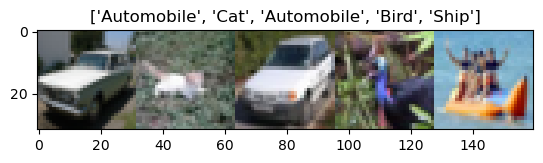

In [26]:
indices = np.random.choice(range(sample), size=5, replace=False)
labels_sel = list(map(idx2label, train_labels[indices]))

show_image(train_images[indices])

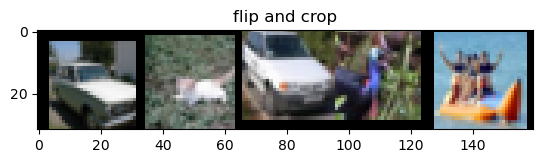

labels : [1 3 1 2 8]


In [27]:
plt.imshow(train_images_flip_and_crop[indices].transpose((1,0,2,3)).reshape((32,-1,3)))
plt.title('flip and crop')
plt.show()
print("labels : {}".format(train_labels[indices]))


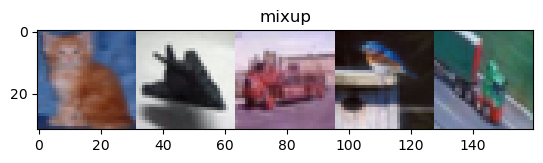

labels : [2.845121  0.2323182 8.380485  2.        8.922561 ]


In [28]:
plt.imshow(train_images_mixup[indices].transpose((1,0,2,3)).reshape((32,-1,3)))
plt.title('mixup')
plt.show()
print("labels : {}".format(train_labels_mixup[indices]))


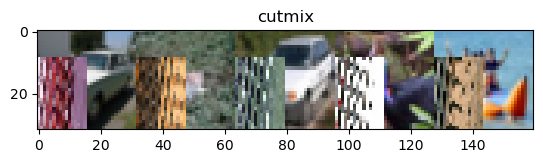

labels : [3.875    3.71875  2.4375   1.28125  7.640625]


In [29]:
plt.imshow(train_images_cutmix[indices].transpose((1,0,2,3)).reshape((32,-1,3)))
plt.title('cutmix')
plt.show()
print("labels : {}".format(train_labels_cutmix[indices]))

<BarContainer object of 10 artists>

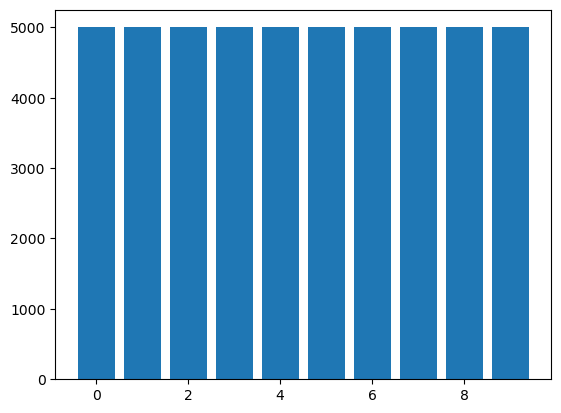

In [30]:
# train_labels에서 label들의 분포를 구해보기
plt.bar([0,1,2,3,4,5,6,7,8,9], tf.keras.utils.to_categorical(train_labels).sum(axis=0))

# STEP 5. 모델링 
## transfer learning 컨셉 이용

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [32]:
# 변환 함수
def one_hot_encoding(image, label):
    """
    label: scalar (0~9), uint8
    반환: (image, label_onehot)
    """
    label_oh = tf.one_hot(label, depth=10)  # (10,)
    # float32로 변환 (cutmix/mixup에서 라벨 실수 연산 필요)
    label_oh = tf.cast(label_oh, tf.float32) 
    return image, label_oh

def random_flip_and_crop(image, label, pad=4):
    """
    image: (32,32,3) float32
    label: (10,) 원-핫(또는 아직 int)도 가능
    """
    # 좌우 뒤집기
    image = tf.image.random_flip_left_right(image)

    # 패딩 후 (32+8=40, 32+8=40)
    image = tf.image.resize_with_crop_or_pad(image, 32 + 2*pad, 32 + 2*pad)
    # 무작위 크롭
    image = tf.image.random_crop(image, size=[32, 32, 3])
    
    return image, label

def cutmix_batch(images, labels, alpha=1.0):
    """
    images: (B, 32, 32, 3) float32
    labels: (B, 10) float32 (원-핫)
    """
    batch_size = tf.shape(images)[0]
    
    # Beta 분포에서 lam 뽑기
    lam = np.random.beta(alpha, alpha)
    lam = tf.cast(lam, tf.float32)

    # 무작위 인덱스 섞기
    indices = tf.random.shuffle(tf.range(batch_size))
    images2 = tf.gather(images, indices)
    labels2 = tf.gather(labels, indices)

    # 사각형 영역 결정
    height = tf.shape(images)[1]
    width = tf.shape(images)[2]
    cut_rat = tf.sqrt(1.0 - lam)  
    cut_h = tf.cast(cut_rat * tf.cast(height, tf.float32), tf.int32)
    cut_w = tf.cast(cut_rat * tf.cast(width, tf.float32), tf.int32)

    cy = tf.random.uniform(shape=[], minval=0, maxval=height, dtype=tf.int32)
    cx = tf.random.uniform(shape=[], minval=0, maxval=width,  dtype=tf.int32)

    y1 = tf.clip_by_value(cy - cut_h // 2, 0, height)
    y2 = tf.clip_by_value(cy + cut_h // 2, 0, height)
    x1 = tf.clip_by_value(cx - cut_w // 2, 0, width)
    x2 = tf.clip_by_value(cx + cut_w // 2, 0, width)
    
    # 개별 샘플마다 사각형을 images2로부터 복사
    def cutmix_one_sample(i):
        img1 = images[i]
        img2 = images2[i]
        # 사각형 영역 업데이트
        indices_ = tf.reshape(
            tf.stack(tf.meshgrid(tf.range(y1, y2), tf.range(x1, x2)), axis=-1),
            [-1, 2]
        )
        updates_ = tf.reshape(img2[y1:y2, x1:x2, :], [-1, 3])
        return tf.tensor_scatter_nd_update(img1, indices_, updates_)

    new_images = tf.map_fn(
        fn=cutmix_one_sample,
        elems=tf.range(batch_size),
        fn_output_signature=tf.float32
    )

    # 실제 잘린 면적 비율
    cut_area = (x2 - x1) * (y2 - y1)
    total_area = width * height
    lam_adj = 1.0 - (tf.cast(cut_area, tf.float32) / tf.cast(total_area, tf.float32))
    
    # 라벨 혼합
    new_labels = lam_adj * labels + (1.0 - lam_adj) * labels2

    return new_images, new_labels

def mixup_batch(images, labels, alpha=1.0):
    """
    images: (B,32,32,3), labels: (B,10) 원-핫
    """
    batch_size = tf.shape(images)[0]
    lam = np.random.beta(alpha, alpha)
    lam = tf.cast(lam, tf.float32)

    # 무작위 인덱스
    indices = tf.random.shuffle(tf.range(batch_size))
    images2 = tf.gather(images, indices)
    labels2 = tf.gather(labels, indices)

    # 블렌딩
    mixed_images = lam * images + (1.0 - lam) * images2
    mixed_labels = lam * labels + (1.0 - lam) * labels2
    return mixed_images, mixed_labels



In [33]:
# tf.datd.Dataset 구성
BATCH_SIZE = 64

# train_ds
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(buffer_size=len(train_images))
train_ds = train_ds.map(one_hot_encoding, num_parallel_calls=tf.data.AUTOTUNE)
# train_ds = train_ds.map(random_flip_and_crop, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
# train_ds = train_ds.map(lambda x, y: cutmix_batch(x, y, alpha=1.0),
#          num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

# test_ds
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.map(one_hot_encoding, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [34]:
# (1) 각 배치의 텐서 사양
print('train_ds.element_spec : {}'.format(train_ds.element_spec))
# (2) 전체 배치 수 (가능하면)
num_batches = train_ds.cardinality()
if num_batches == tf.data.INFINITE_CARDINALITY:
    print("Infinite dataset.")
elif num_batches == tf.data.UNKNOWN_CARDINALITY:
    print("Unknown cardinality.")
else:
    print("Number of batches: {}".format(num_batches.numpy()))
    
print('---------------------------------------------')

# (1) 각 배치의 텐서 사양
print('test_ds.element_spec : {}'.format(test_ds.element_spec))
# (2) 전체 배치 수 (가능하면)
num_batches = test_ds.cardinality()
if num_batches == tf.data.INFINITE_CARDINALITY:
    print("Infinite dataset.")
elif num_batches == tf.data.UNKNOWN_CARDINALITY:
    print("Unknown cardinality.")
else:
    print("Number of batches: {}".format(num_batches.numpy()))
    
print('---------------------------------------------')



train_ds.element_spec : (TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))
Number of batches: 782
---------------------------------------------
test_ds.element_spec : (TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))
Number of batches: 157
---------------------------------------------


In [35]:
# train_expand_images, train_labels로 싱글 label을 처리하는 image classification 초벌 모델 생성

def alexnet_base(input_shape=(32, 32, 3), num_classes=10):
    """
    CIFAR-10 (32x32)용으로 커널 크기, 필터 수를 조정한 AlexNet 간소화 버전
    """
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu',
                      input_shape=input_shape),
        layers.MaxPooling2D(pool_size=2, strides=2),  # 16x16로 Down

        # Conv Block 2
        layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=2, strides=2),  # 8x8로 Down

        # Conv Block 3
        layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
        layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=2, strides=2),  # 4x4로 Down

        # FC Layers
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model



    
    
    

In [36]:
# 모델을 할당받고 서머리 출력
alex = alexnet_base(input_shape=(32, 32, 3), num_classes=10)
alex.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 256)         5

In [37]:
# 만든 모델에 로스와 옵티마이저, 메트릭 설정
alex.compile(loss ="categorical_crossentropy", optimizer="adam", metrics =["accuracy"])

In [38]:
# 만든 모델에 train_expand_images를 학습
# hist = model.fit(train_expand_images.reshape(-1,56,56,1), 
#                 tf.keras.utils.to_categorical(train_labels,10),
#                 validation_data = (test_expand_images.reshape(-1,56,56,1), 
#                 tf.keras.utils.to_categorical(test_labels,10)),
#                 epochs = 15,
#                 verbose = 1
#                 )

alex_hist = alex.fit(train_ds, validation_data=test_ds,
                epochs = 50,
                verbose = 1
                )

Epoch 1/50
782/782 [==============================] - 11s 11ms/step - loss: 1.6051 - accuracy: 0.4016 - val_loss: 1.2212 - val_accuracy: 0.5562
Epoch 2/50
782/782 [==============================] - 8s 10ms/step - loss: 1.1165 - accuracy: 0.6068 - val_loss: 0.9515 - val_accuracy: 0.6627
Epoch 3/50
782/782 [==============================] - 8s 10ms/step - loss: 0.8988 - accuracy: 0.6866 - val_loss: 0.8599 - val_accuracy: 0.6955
Epoch 4/50
782/782 [==============================] - 8s 10ms/step - loss: 0.7673 - accuracy: 0.7340 - val_loss: 0.7983 - val_accuracy: 0.7301
Epoch 5/50
782/782 [==============================] - 8s 10ms/step - loss: 0.6659 - accuracy: 0.7704 - val_loss: 0.7813 - val_accuracy: 0.7408
Epoch 6/50
782/782 [==============================] - 8s 10ms/step - loss: 0.5770 - accuracy: 0.8020 - val_loss: 0.7265 - val_accuracy: 0.7546
Epoch 7/50
782/782 [==============================] - 8s 10ms/step - loss: 0.5055 - accuracy: 0.8232 - val_loss: 0.7434 - val_accuracy: 0.760

In [39]:
#  학습 진행 사항을 출력
